Christabel Membere - 01703600

## A Model that applies a Discrete Wavelet transform to isolated events in a raw current signal

*This notebook contains the core model for the project, utilising discrete wavelet transform (DWT) as a denoising technique. The goal is to develop reconstructed signals that increase the accuracy of delay classification within the Nanopore App. This model processes the raw signals imported as .mat files.*

### Summary of Model Functions

**Calculate_threshold**: Computes the upper (and optionally lower) threshold for peak detection based on the mean and standard deviation of the data.
**Detect_peaks_troughs**: Detects peaks and optionally troughs using the thresholds. Returns indices of detected peaks and troughs.   
**Isolate_events**: Extracts segments around detected peaks from the signal. The size of each segment is determined by window_size.  
**Compute_dwt**: Applies DWT to the signal. Thresholds the wavelet coefficients and reconstructs the signal. Returns the coefficients and the reconstructed signal.   
**Process_all_signals**: Loads an MAT file, extracts all signals then applies the DWT to each event in every signal and finally reconstructs the signals.   
**Plot_signals**: Plots the original and reconstructed signals for the first few signals in the MAT file.

In [1]:
import os 
!pip install numpy scipy matplotlib h5py scikit-learn
import pywt
import tensorflow as tf9o
import numpy 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.io
from dtaidistance import dtw
from scipy.signal import find_peaks
from scipy.io import loadmat
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, log_loss

In [71]:
def calculate_threshold(data, upper_multiplier, lower_multiplier=None):
    """
    Compute upper and optional lower thresholds based on the mean and standard deviation of the data.

    Parameters:
    - data (numpy.ndarray or list): Input data.
    - upper_multiplier (float): Multiplier for the standard deviation to compute the upper threshold.
    - lower_multiplier (float): Multiplier for the standard deviation to compute the lower threshold.

    Returns:
    - upper_threshold (float): Calculated upper threshold.
    - lower_threshold (float): Calculated lower threshold if `lower_multiplier` is provided.
    - mean_val (float): Mean of the data.
    - std_dev (float): Standard deviation of the data.

    Example:
    >>> calculate_threshold([1, 2, 3], 2)
    (mean + 2 * std_dev, mean, std_dev)

    >>> calculate_threshold([1, 2, 3], 2, 1)
    (mean + 2 * std_dev, mean - 1 * std_dev, mean, std_dev)
    """
    std_dev = np.std(data)
    mean_val = np.mean(data)
    upper_threshold = mean_val + upper_multiplier * std_dev

    if lower_multiplier is not None:
        lower_threshold = mean_val - lower_multiplier * std_dev
        return upper_threshold, lower_threshold, mean_val, std_dev

    return upper_threshold, mean_val, std_dev

In [72]:
def detect_peaks_troughs(data, is_resistive=False):
    """
    Detect peaks and troughs in the data based on calculated thresholds.

    Parameters:
    - data (numpy.ndarray or list): Input data for peak/trough detection.
    - is_resistive (bool, optional): If True, detect both peaks and troughs; otherwise, only peaks.

    Returns:
    - upper_peaks (numpy.ndarray): Indices of detected peaks above the upper threshold.
    - lower_peaks (numpy.ndarray or None): Indices of detected troughs below the lower threshold, or None if not applicable.

    """    
    lower_threshold = None
    if is_resistive:
        upper_threshold, lower_threshold, _, _ = calculate_threshold(data, 1.5, 1.5)
    else:
        upper_threshold, _, _ = calculate_threshold(data, 1.5)

    upper_peaks, _ = find_peaks(data, height=upper_threshold, distance=2, width=0.1)
    lower_peaks = None
    if is_resistive:
        lower_peaks, _ = find_peaks(-data, height=-lower_threshold, distance=2, width=0.1)

    return upper_peaks, lower_peaks

In [73]:
def isolate_events(y_data, upper_peaks, window_size=50):
    """
    Isolate segments of the data around detected peaks.

    Parameters:
    - y_data (numpy.ndarray or list): Input data from which segments are isolated.
    - upper_peaks (numpy.ndarray or list): Indices of detected peaks.
    - window_size (int, optional): Size of the segment around each peak. Universal default is 50.

    Returns:
    - event_signals (list of numpy.ndarray): List of data segments centered around each peak.

    """
    event_signals = []

    for peak in upper_peaks:
        start_idx = max(0, peak - window_size // 2)
        end_idx = min(len(y_data), peak + window_size // 2)
        event_signals.append(y_data[start_idx:end_idx])

    return event_signals

In [75]:
def compute_dwt(event_signals, wavelet='db4', level=2, thresh=0.5, mode='soft', target_length=1024):
    """
    Perform Discrete Wavelet Transform on the given event signals and reconstruct the signal with thresholding.

    Parameters:
    - event_signals (numpy.ndarray or list): Input data segments to process.
    - wavelet (str, optional): Wavelet function to use for DWT. Suitable value for effective denoising is 'db4'.
    - level (int, optional): Level of decomposition in DWT is 2.
    - thresh (float, optional): Threshold multiplier for coefficient thresholding is 0.5.
    - mode (str, optional): Thresholding mode. Options are 'soft' or 'hard'. 'soft' is better for smoothing.
    - target_length (int, optional): Desired length of the output signal. Default for our current signals is 1024.

    Returns:
    - coeffs_flat (numpy.ndarray): Flattened array of wavelet coefficients after thresholding.
    - reconstructed_signal (numpy.ndarray): Signal reconstructed from the thresholded coefficients, adjusted to the original length.

    Example:
    >>> compute_dwt([1, 2, 3, 4, 5], wavelet='db4', level=2, thresh=0.5, mode='soft', target_length=1024)
    (array([...]), array([...]))
    """
    
    # Computes and applies DWT
    coeffs = pywt.wavedec(event_signals, wavelet, level=level, mode='per')

    # Finds the max coefficient value for thresholding
    max_coeff = max(np.max(np.abs(c)) for c in coeffs)
    threshold = thresh * max_coeff
    
    # Apply thresholding to each set of wavelet coefficients
    coeffs = [pywt.threshold(c, value=threshold, mode=mode) for c in coeffs]
    
    # Flatten coefficients for analysis 
    coeffs_flat = np.hstack(coeffs)
    
    # Pad the flattened coefficients to ensure all outputs are of the same length
    if len(coeffs_flat) < target_length:
        coeffs_flat = np.pad(coeffs_flat, (0, target_length - len(coeffs_flat)), 'constant', constant_values=np.nan)
    
    # Reconstruct the signal from threshold coefficients
    reconstructed_signal = pywt.waverec(coeffs, wavelet, mode='per')
    
    # Trim or pad the reconstructed signal to ensure the same length as the original signal
    if len(reconstructed_signal) > len(event_signals):
        reconstructed_signal = reconstructed_signal[:len(event_signals)]
    
    return coeffs_flat, reconstructed_signal

In [76]:
def process_all_signals(file_path, wavelet='db4', level=2, thresh=0.5, mode='soft', target_length=1024):
    """
    Process all signals in a .mat file (usually 4000 signals per file) to perform wavelet transform after peak detection and event isolation.

    Parameters:
    - file_path (str): Path to the .mat file containing the signals.
    - wavelet (str): Type of wavelet used for Discrete Wavelet Transform (DWT). Default is 'db4'.
    - level (int): Level of decomposition for DWT. Default is 2.
    - thresh (float): Threshold for wavelet coefficient thresholding. Default is 0.5.
    - mode (str): Thresholding mode ('soft' or 'hard'). Default is 'soft'.
    - target_length (int): Desired length of the reconstructed signal. Default is 1024.

    Returns:
    - results (list): A list of dictionaries, each containing:
         original_signal
         reconstructed_signal: The signal after applying DWT and thresholding.
         event_signals: List of isolated event signals based on detected peaks.

    Note: The function skips signals with incompatible data structures. 

    """
    # Load the .mat file and extract all the signals
    mat_data = scipy.io.loadmat('/Users/christabel/Documents/MASTERS/PROJECT/MATLAB/Final_array.mat')
    signals = mat_data['Event']
    signal_count = signals.size
    results = []

    for i in range(signal_count):
        # Extract and flatten the raw signal
        raw_signal = signals[0][i]['RawSignal']
        raw_signal = raw_signal[0][0]
        
        # Ensure raw_signal is 1D
        if isinstance(raw_signal, np.ndarray) and raw_signal.ndim > 1:
            raw_signal = raw_signal.flatten()
        
        if not isinstance(raw_signal, (np.ndarray, list)):
            print(f"Skipping signal {i+1}: incompatible data structure.")
            continue

        # Convert raw_signal to a NumPy array
        raw_signal = np.array(raw_signal)

        # Detect peaks and isolate events
        upper_peaks, lower_peaks = detect_peaks_troughs(raw_signal, is_resistive=True)
        event_signals = isolate_events(raw_signal, upper_peaks, window_size=50)

        # Compute DWT and reconstruct signal
        coeffs_flat, reconstructed_signal = compute_dwt(raw_signal, wavelet=wavelet, level=level, thresh=thresh, mode=mode, target_length=target_length)

        # Store only the processed raw signal, not the entire signals array
        results.append({
            'original_signal': raw_signal,
            'reconstructed_signal': reconstructed_signal,
            'event_signals': event_signals
        })

    return results

In [77]:
def plot_signals(results, num_signals=2):
    """
    Plots the first `num_signals` raw signals and their corresponding reconstructed signals.

    Parameters:
    - results: List of dictionaries containing 'original_signal' and 'reconstructed_signal'.
    - num_signals: Number of signals to plot.
    """
    plt.figure(figsize=(15, 5))
    
    num_plots = 2
    
    for i in range(num_plots):
        raw_signal = results[i]['original_signal']
        reconstructed_signal = results[i]['reconstructed_signal']
        
        # Ensure raw_signal and reconstructed_signal are numpy arrays
        if isinstance(raw_signal, (list, tuple)):
            raw_signal = np.array(raw_signal)
        if isinstance(reconstructed_signal, (list, tuple)):
            reconstructed_signal = np.array(reconstructed_signal)
        
        # Convert raw_signal to 1D if necessary
        if raw_signal.ndim > 1:
            raw_signal = raw_signal.flatten()
        
        if raw_signal.ndim != 1:
            print(f"Warning: raw_signal is not 1D for signal {i+1}.")
            continue
        if reconstructed_signal.ndim != 1:
            print(f"Warning: reconstructed_signal is not 1D for signal {i+1}.")
            continue
        
        plt.subplot(num_plots, 2, 2*i + 1)
        plt.plot(raw_signal, label='Original Signal')
        plt.title(f'Original Signal {i+1}')
        plt.xlabel('Time (ms)')
        plt.ylabel('Current (A)')
        plt.legend()
        
        plt.subplot(num_plots, 2, 2*i + 2)
        plt.plot(reconstructed_signal, label='Reconstructed Signal', color='red')
        plt.title(f'Reconstructed Signal {i+1}')
        plt.xlabel('Time (ms)')
        plt.ylabel('Current (A)')
        plt.legend()

    plt.tight_layout()
    plt.savefig('dwt10nM.png', format='png')
    plt.show()

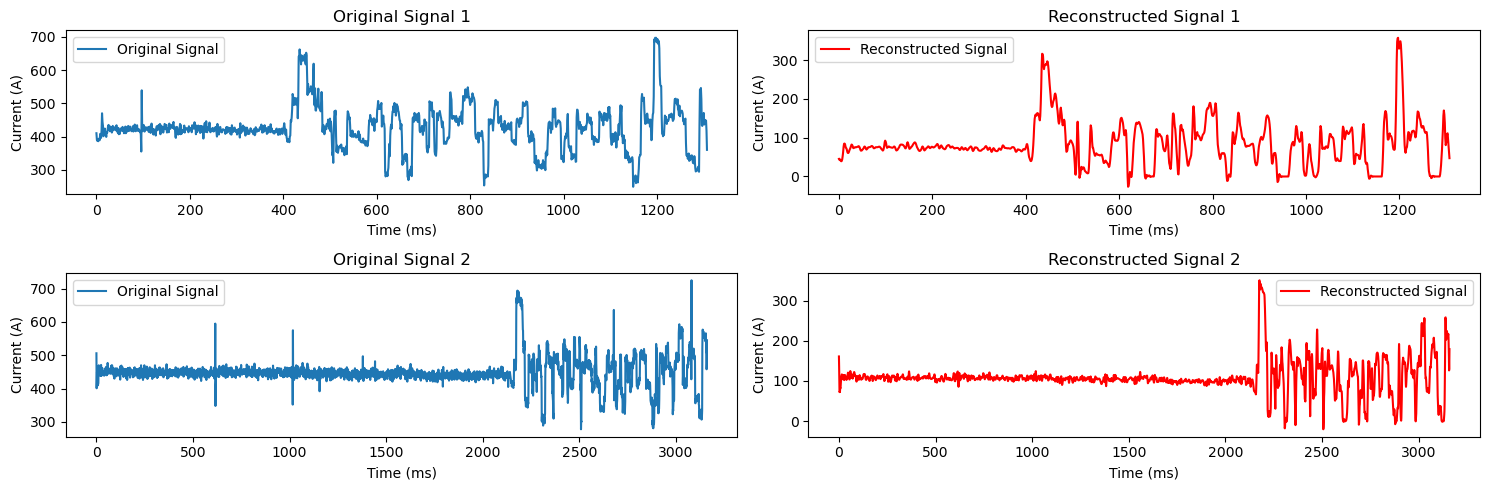

In [78]:
results = process_all_signals('/Users/christabel/Documents/MASTERS/PROJECT/MATLAB/Final_array_10nM_0.mat')
plot_signals(results, num_signals=2)

### Future work: Save Reconstructed signal as a python list

In [79]:
import numpy as np
import scipy.io
import pywt
import pickle

def save_reconstructed_signals(file_path, output_file='reconstructed_signals.pkl', wavelet='db4', level=2, thresh=0.5, mode='soft', target_length=1024):
    """
    Process signals from a .mat file, perform Discrete Wavelet Transform and save reconstructed signals.

    Parameters: All the same parameters have been used as prior code. 
    Process: In particular this function saves and stores the reconstructed signals to a pickle file for loading into MATLAB to analyse.
    
    """
    def compute_dwt(raw_signal, wavelet='db4', level=2, thresh=0.5, mode='soft', target_length=1024):
        # Compute DWT
        coeffs = pywt.wavedec(raw_signal, wavelet, level=level, mode='per')

        # Apply thresholding to coefficients
        max_coeff = max(np.max(np.abs(c)) for c in coeffs)
        threshold = thresh * max_coeff
        coeffs = [pywt.threshold(c, value=threshold, mode=mode) for c in coeffs]
        
        # Flatten coefficients for analysis (optional)
        coeffs_flat = np.hstack(coeffs)
        
        # Pad the coefficients to ensure all outputs are of the same length
        if len(coeffs_flat) < target_length:
            coeffs_flat = np.pad(coeffs_flat, (0, target_length - len(coeffs_flat)), 'constant', constant_values=np.nan)
        
        # Reconstruct the signal from coefficients
        reconstructed_signal = pywt.waverec(coeffs, wavelet, mode='per')
        
        # Ensure the reconstructed signal has the same length as the original signal
        if len(reconstructed_signal) > len(raw_signal):
            reconstructed_signal = reconstructed_signal[:len(raw_signal)]
        
        return coeffs_flat, reconstructed_signal

    # Load data from .mat file
    mat_data = scipy.io.loadmat(file_path)
    signals = mat_data['Event']
    signal_count = signals.size
    reconstructed_signals = []

    for i in range(signal_count):
        raw_signal = signals[0][i]['RawSignal']
        raw_signal = raw_signal[0][0]
        
        # Ensure raw_signal is 1D
        if isinstance(raw_signal, np.ndarray) and raw_signal.ndim > 1:
            raw_signal = raw_signal.flatten()
        
        if not isinstance(raw_signal, (np.ndarray, list)):
            print(f"Skipping signal {i+1}: incompatible data structure.")
            continue

        # Ensure raw_signal is a NumPy array
        raw_signal = np.array(raw_signal)

        # Compute DWT and reconstruct signal
        coeffs_flat, reconstructed_signal = compute_dwt(raw_signal, wavelet=wavelet, level=level, thresh=thresh, mode=mode, target_length=target_length)
        
        # Store reconstructed signal
        reconstructed_signals.append(reconstructed_signal)

    # Save the reconstructed signals list to a file
    with open(output_file, 'wb') as f:
        pickle.dump(reconstructed_signals, f)
        

In [80]:
# Call the new function to save reconstructed signals
save_reconstructed_signals('/Users/christabel/Documents/MASTERS/PROJECT/MATLAB/Final_array.mat', output_file='reconstructed_signals.pkl')

In [67]:
# Josh method for loading 4000 raw signals 

File = '/Users/christabel/Documents/MASTERS/PROJECT/Data/FAP43765_pass_67f8872c_0-Bar15-control.fEvents_All.mat'
MAT = loadmat(File)
 
Signal = MAT['Event']
signal_size = Signal.size
 
NEWLIST = []
 
for i in range(signal_size):
    raw_signal = Signal[0][i]['RawSignal']
    NEWLIST.append(raw_signal)

# Check the length of NEWLIST to confirm it has 4000 raw signals
print(f"Number of raw signals: {len(NEWLIST)}")

Number of raw signals: 4000


In [ ]:
# def process_mat_file(file_path, target_length=1024):
#     """
#     Load a .mat file containing events, apply DWT to each event, and return the results.
    
#     Args:
#         file_path (str): The path to the .mat file containing the events data.
#         target_length (int): The desired length of the output array for DWT coefficients. (Default = 1024)
    
#     Returns:
#         list: A list of arrays containing the DWT coefficients for each event.
#     """
#     # Load the .mat file
#     data = loadmat('/Users/christabel/Documents/MASTERS/PROJECT/MATLAB/Final_array.mat')
    
#     # Extract events from the loaded data (assuming the key is 'events')
#     events = data['events']
    
#     # Apply DWT to each event
#     dwt_results = []
#     for event in events:
#         dwt_result = compute_dwt(event.flatten(), target_length=target_length)
#         dwt_results.append(dwt_result)
    
#     return dwt_results

# # Example usage
# file_path = '/Users/christabel/Documents/MASTERS/PROJECT/MATLAB/Final_array.mat'
# dwt_results = process_mat_file(file_path, target_length=1024)

# # Print the shape of DWT results for verification
# for i, dwt_result in enumerate(dwt_results):
#     print(f"Event {i} DWT result shape: {dwt_result.shape}")

In [ ]:
# def process_signal1_file(file_path, wavelet='db4', level=2, thresh=0.5, mode='soft', target_length=1024):
#     """
#     Load a .mat file containing events, apply DWT to each event and return the results.
    
#     Args:
#         file_path (str): The path to the .mat file containing the events data.
#         target_length (int): The desired length of the output array for DWT coefficients. (1024)
    
#     Returns:
#         list: A list of arrays containing the DWT coefficients for each event.
#     """
    
#     data = loadmat('/Users/christabel/Documents/MASTERS/PROJECT/MATLAB/signal1.mat')
#     key = 'rawsig'
#     if key not in data:
#         raise KeyError(f"Key '{key}' not found in the .mat file.")

#     #Extract and flatten the array to get individual signals
#     signal = data[key].flatten()  
#     upper_peaks, lower_peaks = detect_peaks_troughs(signal, is_resistive=True)
#     event_signals = isolate_events(signal, upper_peaks, window_size=1)
#     coeffs_flat, reconstructed_signal = compute_dwt(signal, wavelet=wavelet, level=level, thresh=thresh, mode=mode, target_length=target_length)
    
#     return signal, reconstructed_signal, event_signals

In [68]:
#PLOTTING 1 SIGNAL
# file_path = '/Users/christabel/Documents/MASTERS/PROJECT/MATLAB/signal1.mat'

# # Process the single signal
# signal, reconstructed_signal, event_signals = process_signal1_file(
#     file_path, wavelet='db4', level=2, thresh=0.5, mode='soft', target_length=1024
# )

# # Plot the original and reconstructed signals
# plot_single_signal(signal, reconstructed_signal, event_signals)

# # Calculate the DTW distance between the original signal and the reconstructed signal
# distance = dtw.distance(signal, reconstructed_signal)
# print(f"DTW Distance: {distance}")

In [69]:
# def plot_single_signal(signal, reconstructed_signal, event_signals, num_events=5):
#         plt.figure(figsize=(15, 10))
        
#         plt.subplot(2, 1, 1)
#         plt.plot(signal, label='Original Signal')
#         plt.title('Original Signal')
#         plt.xlabel('Sample Index')
#         plt.ylabel('Current (A)')
#         plt.legend()
        
#         plt.subplot(2, 1, 2)
#         plt.plot(reconstructed_signal, label='Reconstructed Signal', color='red')
#         plt.title('Reconstructed Signal')
#         plt.xlabel('Sample Index')
#         plt.ylabel('Current (A)')
#         plt.legend()
        
#         plt.tight_layout()
    
#         plt.show()

## Model Version 1: (July)

In [25]:
# def calculate_threshold(data, upper_multiplier, lower_multiplier=None):
    
#     std_dev = np.std(data)
#     mean_val = np.mean(data)
#     upper_threshold = mean_val + upper_multiplier * std_dev

#     if lower_multiplier is not None:
#         lower_threshold = mean_val - lower_multiplier * std_dev
#         return upper_threshold, lower_threshold, mean_val, std_dev

#     return upper_threshold, mean_val, std_dev

# def detect_peaks_troughs(data, x_data, is_resistive=False, save_file=None, plot=False):
#     lower_threshold = None

#     if is_resistive:
#         upper_threshold, lower_threshold, mean_val, std_dev = calculate_threshold(data, 10, 10)
#     else:
#         upper_threshold, mean_val, std_dev = calculate_threshold(data, 10)

#     upper_peaks, upper_properties = find_peaks(data, height=upper_threshold, distance=200, width=30)

#     # Filter out peaks that are too narrow
#     valid_peaks = []
#     for peak in upper_peaks:
#         left_bound = peak
#         while left_bound > 0 and data[left_bound] >= upper_threshold:
#             left_bound -= 1
#         right_bound = peak
#         while right_bound < len(data) and data[right_bound] >= upper_threshold:
#             right_bound += 1
#         if right_bound - left_bound >= 10:
#             valid_peaks.append(peak)

#     upper_peaks = np.array(valid_peaks)

#     lower_peaks, lower_properties = None, None
#     if is_resistive:
#         lower_peaks, lower_properties = find_peaks(-data, height=-lower_threshold, distance=200, width=30)

#     return upper_threshold, lower_threshold, upper_peaks, upper_properties, lower_peaks, lower_properties 
# def previous_peak_index(trough_index, peaks):
#     preceding_peaks = peaks[peaks < trough_index]
#     if not preceding_peaks.size:
#         return None
#     return preceding_peaks[-1]

# def next_peak_index(trough_index, peaks):
#     succeeding_peaks = peaks[peaks > trough_index]
#     if not succeeding_peaks.size:
#         return None
#     return succeeding_peaks[0]

# def calculate_event_boundaries(center_index, peak_widths, signal_length, buffer=200):
#     width = peak_widths[center_index]
#     start_index = max(0, center_index - int(width / 2) - buffer)
#     end_index = min(signal_length, center_index + int(width / 2) + buffer)
#     return start_index, end_index

# def isolate_events(x_data, y_data, upper_peaks, upper_properties, lower_peaks=None, lower_properties=None):
#     event_signals = []
#     event_times = []
#     event_indices = []
#     processed_peaks = set()

#     mean_signal = np.mean(y_data)
#     std_signal = np.std(y_data)

#     if lower_peaks is None:
#         for peak, width in zip(upper_peaks, upper_properties['widths']):
#             start_idx = max(0, peak - int(width / 2)) - 300
#             end_idx = min(len(y_data), peak + int(width / 2)) + 300
#             if (end_idx - start_idx) < 1000:
#                 event_signals.append(y_data[start_idx:end_idx])
#                 event_times.append(x_data[start_idx:end_idx])
#                 event_indices.append([start_idx, end_idx])
#             else:
#                 start_idx = peak - 500
#                 end_idx = peak + 500
#                 event_signals.append(y_data[start_idx:end_idx])
#                 event_times.append(x_data[start_idx:end_idx])
#                 event_indices.append([start_idx, end_idx])
#     else:
#         for trough in lower_peaks:
#             prev_peak = previous_peak_index(trough, upper_peaks)
#             next_peak = next_peak_index(trough, upper_peaks)
#             selected_peak = None

#             if prev_peak is not None and next_peak is not None:
#                 if abs(trough - prev_peak) < abs(trough - next_peak):
#                     selected_peak = prev_peak
#                     start_width = upper_properties['widths'][np.where(upper_peaks == prev_peak)[0][0]]
#                     end_width = lower_properties['left_ips'][np.where(lower_peaks == trough)[0][0]]
#                 else:
#                     selected_peak = next_peak
#                     start_width = lower_properties['right_ips'][np.where(lower_peaks == trough)[0][0]]
#                     end_width = upper_properties['widths'][np.where(upper_peaks == next_peak)[0][0]]
#             elif prev_peak is not None:
#                 selected_peak = prev_peak
#                 start_width = upper_properties['widths'][np.where(upper_peaks == prev_peak)[0][0]]
#                 end_width = lower_properties['left_ips'][np.where(lower_peaks == trough)[0][0]]
#             elif next_peak is not None:
#                 selected_peak = next_peak
#                 start_width = lower_properties['right_ips'][np.where(lower_peaks == trough)[0][0]]
#                 end_width = upper_properties['widths'][np.where(upper_peaks == next_peak)[0][0]]

#             if selected_peak is not None and selected_peak not in processed_peaks:
#                 if trough < selected_peak:
#                     start_idx = start_width - 300
#                     end_idx = min(len(y_data), selected_peak + int(end_width / 2)) + 200
#                 else:
#                     start_idx = max(0, selected_peak - int(start_width / 2)) - 200
#                     end_idx = selected_peak + end_width + 300

#                 event_signals.append(y_data[start_idx:end_idx])
#                 event_times.append(x_data[start_idx:end_idx])
#                 event_indices.append([start_idx, end_idx])
#                 processed_peaks.add(selected_peak)

#         for peak, width in zip(upper_peaks, upper_properties['widths']):
#             if peak not in processed_peaks:
#                 start_idx = max(0, peak - int(width / 2)) - 200
#                 end_idx = min(len(y_data), peak + int(width / 2)) + 200
#                 event_signals.append(y_data[start_idx:end_idx])
#                 event_times.append(x_data[start_idx:end_idx])
#                 event_indices.append([start_idx, end_idx])

#     return event_times, event_signals, event_indices

# def isolate_non_resistive_events(x_data, y_data, upper_peaks, is_NR=False, is_NP=False):
#     event_signals = []
#     event_times = []

#     if is_NR:
#         for peak in upper_peaks:
#             start_idx = peak - 1000
#             end_idx = peak + 1000
#             event_signals.append(y_data[start_idx:end_idx])
#             event_times.append(x_data[start_idx:end_idx])
#     else:
#         for peak in upper_peaks:
#             start_idx = peak - 400 if is_NP else peak - 500
#             end_idx = peak + 400 if is_NP else peak + 500
#             event_signals.append(y_data[start_idx:end_idx])
#             event_times.append(x_data[start_idx:end_idx])

#     return event_times, event_signals
# def compute_dwt(signal, target_length=1024):
#     """
#     Compute the Discrete Wavelet Transform (DWT) of the given signal, pad the wavelet coefficients,
#     and return a flattened array of coefficients with a fixed length.
    
#     Args:
#         signal (array): The input signal.
#         target_length (int): The desired length of the output array. (Default = 1024)
    
#     Returns:
#         np.ndarray: Flattened and padded array of DWT coefficients.
#     """
#     # Compute wavelet decomposition coefficients
#     coeffs = pywt.wavedec(signal, 'db1', level=4)
#     coeffs_flat = np.hstack(coeffs)
    
#     # Pad the coefficients to ensure all outputs are of the same length
#     if len(coeffs_flat) < target_length:
#         coeffs_flat = np.pad(coeffs_flat, (0, target_length - len(coeffs_flat)), 'constant', constant_values=np.nan)
    
#     # Reconstruct the signal from coefficients
#     reconstructed_signal = pywt.waverec(coeffs, 'db1', mode='per')
    
#     # Ensure the reconstructed signal has the same length as the original signal
#     if len(reconstructed_signal) > len(signal):
#         reconstructed_signal = reconstructed_signal[:len(signal)]
    
#     return coeffs_flat, reconstructed_signal
# def process_mat_file(file_path, target_length=1024):
#     """
#     Load a .mat file containing events, apply DWT to each event and return the results.
    
#     Args:
#         file_path (str): The path to the .mat file containing the events data.
#         target_length (int): The desired length of the output array for DWT coefficients. (1024)
    
#     Returns:
#         list: A list of arrays containing the DWT coefficients for each event.
#     """
#     # Load the .mat file
#     data = loadmat('/Users/christabel/Documents/MASTERS/PROJECT/MATLAB/Final_array.mat')
    
#     key = 'Final_array'
#     if key not in data:
#         raise KeyError(f"Key '{key}' not found in the .mat file.")
    
#     events = data[key].flatten()  # Extract and flatten the array to get individual signals

#     dwt_results = []
#     reconstructed_signals = []

#     for event in events:
#         if isinstance(event, np.ndarray) and event.size > 1:
#             # Apply DWT and reconstruct each event
#             dwt_result, reconstructed_signal = compute_dwt(event, target_length=target_length)
#             dwt_results.append(dwt_result)
#             reconstructed_signals.append(reconstructed_signal)

#     return dwt_results, reconstructed_signals
# def plots(signals, reconstructed_signals, num_plots=5):

    
#     if len(signals) == 0 or len(reconstructed_signals) == 0:
#         print("No signals to plot.")
#         return
        
#     num_plots = min(num_plots, len(signals), len(reconstructed_signals))
#     plt.figure(figsize=(15, 5 * num_plots))
    
#     for i in range(num_plots):
#         plt.subplot(num_plots, 2, 2 * i + 1)
#         plt.plot(signals[i], color = 'blue')
#         plt.title(f'Original Signal {i+1}')
#         plt.xlabel('Sample Index')
#         plt.ylabel('Current (A)')
#         plt.ylim(0, 800) 
#         plt.yticks(range(0, 810, 100))  

#         plt.subplot(num_plots, 2, 2 * i + 2)
#         plt.plot(reconstructed_signals[i], color = 'red')
#         plt.title(f'Reconstructed Signal {i+1}')
#         plt.xlabel('Sample Index')
#         plt.ylabel('Current (A)')
        
#     plt.tight_layout()
#     plt.show()

# file_path = '/Users/christabel/Documents/MASTERS/PROJECT/MATLAB/Final_array.mat'
# mat_data = loadmat(file_path)
# dwt_results, reconstructed_signals = process_mat_file(file_path, target_length=1024)

# signals = mat_data['Final_array'].flatten()

# signals = [signal.flatten() for signal in signals]
# reconstructed_signals = [reconstructed.flatten() for reconstructed in reconstructed_signals]

# plots(signals, reconstructed_signals, num_plots=5)